# Generate example, train and test data

In [1]:
import torch

# 1. define side length of one pattern. pattern are two-dimensional, shape: (S,S)
S = 6

# 2. define how much different base patterns we want to simulate
N_base_patterns = 5

# 3. define how many noisy variants of each base patterns we want to generate
N_training_patterns_per_base_pattern = 100

# 4. compute resulting total number of patterns we will generate
N_total_training_patterns = N_base_patterns * N_training_patterns_per_base_pattern

# 5. prepare data structures to hold input patterns x
# and corresponding one-hot-encoded label vectors y
x = torch.zeros(N_total_training_patterns, S**2)
y = torch.zeros(N_total_training_patterns, N_base_patterns)

# 6. generate desired number of base patterns of shape (2,2)
print(f"Here are all {N_base_patterns} base patterns:")
list_base_patterns = []
for base_pattern_nr in range(N_base_patterns):
    new_base_pattern = torch.randn(2,2) * 0.1
    print(new_base_pattern)
    list_base_patterns.append( new_base_pattern )

# 7. generate training patterns of shape (S,S)
#    where the base pattern of shape (2,2) is in the center of this pattern
print(f"\nHere are some examples of the {N_total_training_patterns} patterns in total:")
pattern_nr = 0
for base_pattern_idx in range(N_base_patterns):
    
    # 7.1 get the next base pattern
    base_pattern = list_base_patterns[base_pattern_idx]
    
    # 7.2 create trainings patterns with the base pattern in the center
    for nr_training_pattern in range(N_training_patterns_per_base_pattern):
        
        # generate random input pattern with defined center values
        #pattern = torch.randn(S, S)
        pattern = torch.rand(S,S)
        pattern[S//2-1:S//2+1, S//2-1:S//2+1 ] = base_pattern
        
        # show the first 3 generated pattern
        if pattern_nr < 3:
            print(pattern)
            #print(pattern.view(S**2))
        
        # store new input pattern
        x[pattern_nr,:] = pattern.view(S**2)
        
        # generate new target pattern
        one_hot_vec = torch.zeros(N_base_patterns)
        one_hot_vec[base_pattern_idx] = 1
                
        # store target pattern
        y[pattern_nr,:] = one_hot_vec
        
        pattern_nr += 1

Here are all 5 base patterns:
tensor([[-0.0062, -0.1187],
        [ 0.1358,  0.1564]])
tensor([[ 0.1473,  0.0067],
        [-0.0309,  0.2618]])
tensor([[-0.0192,  0.0304],
        [ 0.0838,  0.1170]])
tensor([[ 0.1180, -0.1575],
        [-0.0359,  0.0127]])
tensor([[-0.0375, -0.0354],
        [ 0.0154,  0.0167]])

Here are some examples of the 500 patterns in total:
tensor([[ 7.9332e-02,  7.4208e-04,  9.2026e-01,  6.5755e-01,  7.4244e-01,
          5.9322e-01],
        [ 3.7820e-01,  7.0711e-01,  7.5938e-02,  3.3751e-01,  7.8243e-02,
          1.2814e-01],
        [ 6.9194e-01,  1.1008e-01, -6.2069e-03, -1.1869e-01,  1.2536e-01,
          9.0290e-01],
        [ 6.1832e-01,  5.2795e-02,  1.3581e-01,  1.5637e-01,  8.4879e-01,
          3.2193e-01],
        [ 1.2002e-01,  1.2569e-01,  4.8343e-02,  7.7959e-01,  7.2645e-01,
          3.9085e-01],
        [ 4.2486e-01,  7.1451e-02,  7.6220e-01,  4.0618e-01,  5.5265e-01,
          7.6041e-01]])
tensor([[ 0.7144,  0.1634,  0.1627,  0.8896,  0.

In [2]:
r = torch.randperm(N_total_training_patterns)
x = x[r, :]
y = y[r, :]

In [3]:
train_ratio = 0.8
train_N = int(train_ratio * x.shape[0])
x_train = x[:train_N]
y_train = y[:train_N]
x_test  = x[train_N:]
y_test  = y[train_N:]

In [4]:
x_train.shape

torch.Size([400, 36])

In [5]:
y_train.shape

torch.Size([400, 5])

In [6]:
x_test.shape

torch.Size([100, 36])

In [7]:
y_test.shape

torch.Size([100, 5])

# SOMLP model definition

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SOMLP(nn.Module):
    def __init__(self, nr_inputs, nr_outputs, use_hidden_layer=False, nr_neurons_hidden1=20):
        super().__init__()
        
        self.use_hidden_layer = use_hidden_layer
        if self.use_hidden_layer:
            self.fc1 = nn.Linear(nr_inputs, nr_neurons_hidden1)
            self.actfunc = torch.nn.ReLU()            
            self.fc2 = nn.Linear(nr_neurons_hidden1, nr_outputs)        
        else:
            self.fc1 = nn.Linear(nr_inputs, nr_outputs)

    def forward(self, input_vec):
        if self.use_hidden_layer:
            x = self.fc1(input_vec)
            x = self.actfunc(x)
            x = self.fc2(x)
        else:
            x = self.fc1(input_vec)
        
        bmu = torch.argmax( x ).item()
        
        return x, bmu

In [9]:
net = SOMLP(S**2, N_base_patterns, True)
net

SOMLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)

In [10]:
torch.get_default_dtype()

torch.float32

In [11]:
input_vec1 = torch.arange(S**2, dtype=torch.float32)
input_vec1

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35.])

In [12]:
input_vec1.dtype

torch.float32

In [13]:
net.forward( input_vec1 )

(tensor([ 6.4687,  1.2490,  7.6822, -2.1401, -1.1413], grad_fn=<AddBackward0>),
 2)

In [14]:
net( input_vec1 )

(tensor([ 6.4687,  1.2490,  7.6822, -2.1401, -1.1413], grad_fn=<AddBackward0>),
 2)

# SOMLP training

SOMLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)
train_step= 0
train_step= 1000
counter 'neuron was BMU' in the last 1000 steps: tensor([  0.,  11., 474., 514.,   1.])
neuron outputs now: tensor([0.0097, 0.3661, 1.0141, 1.0475, 0.7309], grad_fn=<AddBackward0>)
train_step= 2000
counter 'neuron was BMU' in the last 1000 steps: tensor([  0.,  11., 474., 514.,   1.])
neuron outputs now: tensor([0.0198, 0.3292, 0.9671, 1.0096, 0.7530], grad_fn=<AddBackward0>)
train_step= 3000
counter 'neuron was BMU' in the last 1000 steps: tensor([  0.,  11., 474., 514.,   1.])
neuron outputs now: tensor([0.0084, 0.2596, 0.8626, 0.8778, 0.5918], grad_fn=<AddBackward0>)
train_step= 4000
counter 'neuron was BMU' in the last 1000 steps: tensor([  0.,  11., 474., 514.,   1.])
neuron outputs now: tensor([-0.0250,  0.3144,  1.0489,  1.0573,  0.6112], grad_fn=<AddBackward0>)
train_step= 5000
counter 'neuron was BMU'

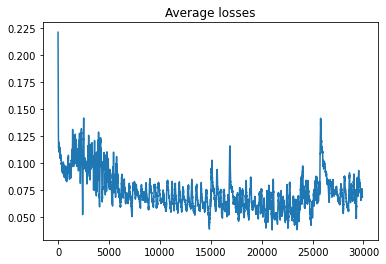

In [41]:
import numpy

BMU_TARGET_VALUE = 1.0
BMU_NEIGHBORS_TARGET_VALUE = 1.0

def get_neighbors1d(neuron_idx, nr_neurons):
    
    # edge neurons?
    if neuron_idx == 0:
        return [nr_neurons-1, neuron_idx+1]
    if neuron_idx == nr_neurons-1:
        return [neuron_idx-1, 0]
    
    # inner neuron
    return [neuron_idx-1, neuron_idx+1]


# prepare neural network
nr_inputs  = S**2
nr_hidden1 = 20
nr_outputs = N_base_patterns
net = SOMLP(nr_inputs, nr_outputs, use_hidden_layer=True, nr_neurons_hidden1=nr_hidden1) # SOMLP
#net = SOMLP(nr_inputs, nr_outputs, use_hidden_layer=False) # SO-Perceptron
print(net)

# prepare loss and optimizer
#loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

N_train_steps = 30000

losses = []
avg_losses = []
bmus = []
for train_step in range(N_train_steps):   
    
    # 1. get a random training sample
    #    consisting of an input vec and a teacher vec
    random_idx = numpy.random.randint(low=0, high=x_train.shape[0])  
    input_vec   = x_train[random_idx]
    
    # 2. sets gradients to 0 before calculating loss   
    # For: net.zero_grad() vs optim.zero_grad() see:    
    # https://stackoverflow.com/questions/61898668/net-zero-grad-vs-optim-zero-grad-pytorch
    #net.zero_grad()
    optimizer.zero_grad()

    # 3. feed forward step
    output_vec, bmu = net( input_vec )
    
    # 4. get BMU neighbors
    bmu_neighbors = get_neighbors1d( bmu, nr_outputs )
    
    # 5. prepare teacher vector
    teacher_vec = torch.zeros( nr_outputs )
    teacher_vec[bmu] = BMU_TARGET_VALUE
    for neighbor in bmu_neighbors:
        teacher_vec[neighbor] = BMU_NEIGHBORS_TARGET_VALUE
    #print( f"bmu={bmu}, neighbors={bmu_neighbors}" )
    #print( f"teacher_vec={teacher_vec}" )
    
    # 6. compute loss
    loss = loss_fn(output_vec, teacher_vec)
    
    # 7. apply this loss backwards thru the network's parameters
    loss.backward() 
    
    # 8. change weights, i.e.
    #    attempt to optimize weights to account for loss/gradients
    optimizer.step() 

    # 9. save loss
    loss_value = loss.detach().numpy()
    losses.append( loss_value )
    if len(losses)>100:
        avg_losses.append( numpy.mean(losses[-100:]) )    
    
    # 10. save information which neuron was BMU
    bmus.append( bmu )
    X = 1000
    if len(bmus)>X and len(bmus) % X == 0:
        # count how often each neuron was BMU
        # in the last X steps
        last_bmus = bmus[-X:]
        counter = torch.zeros(nr_outputs)
        for i in range(X):
            counter[bmus[i]] += 1
        print(f"counter 'neuron was BMU' in the last {X} steps: {counter}")
        print(f"neuron outputs now: {output_vec}")
    
    # 11. show progress
    if train_step % 1000 == 0:
        print("train_step=", train_step)
        
import matplotlib.pyplot as plt
plt.plot( avg_losses )
plt.title("Average losses")
plt.show()

# Distinctiveness of patterns

In [42]:
x_train.shape

torch.Size([400, 36])

In [43]:
y_train.shape

torch.Size([400, 5])

In [44]:
net

SOMLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)

In [45]:
x_test.shape

torch.Size([100, 36])

In [46]:
y_test.shape

torch.Size([100, 5])

In [47]:
# 1. define whether we want to test the SOMLP
#    using the train or the test data
data_source = "train"
#data_source = "test"

if data_source == "train":
    x_data = x_train
    y_data = y_train
elif data_source == "test":
    x_data = x_test
    y_data = y_test

N = x_data.shape[0]

# 2. prepare result matrix that shall reflect
#    how good we can discriminate the patterns
D = torch.zeros( (N_base_patterns, nr_outputs) )

# 2. iterate over all patterns ...
for pattern_idx in range(N):
    
    # get next input pattern
    input_vec = x_data[pattern_idx]
    
    # get corresponding class label
    class_label = torch.argmax( y_data[pattern_idx] )
    
    # feed-forward the pattern thru the network
    output_vec, bmu = net( input_vec )    
    
    # increase counter in D at (class_label, bmu)
    D[class_label, bmu] += 1

In [50]:
# columns: neuron ID
# rows: class labels
# D(c,n): how often was neuron n BMU for pattern c?
D

tensor([[ 0.,  2., 42., 44.,  0.],
        [ 0.,  7., 41., 31.,  0.],
        [ 0.,  4., 30., 47.,  0.],
        [ 0.,  3., 37., 34.,  0.],
        [ 0.,  4., 41., 33.,  0.]])

In [49]:
sum(D[:,1])

tensor(20.)